# Maternity Episode Cost & Risk Analytics  
### Healthcare Payer Strategy & Predictive Modeling Project

Simulated real-world payer analytics project using commercial maternity claims data.

---

## Objective
Identify high-cost pregnancy episodes, understand cost drivers, predict high-risk cases early, and estimate cost-reduction opportunities for a payer.

## Dataset
- Commercial maternity claims (medical + pharmacy + member eligibility)
- ~2,000 delivery episodes
- Episode-level cost aggregation across pregnancy → delivery → postpartum

## Tools Used
- Python
- Pandas
- Scikit-learn
- Healthcare claims logic (DRG, diagnosis coding, LOS, cost aggregation)

---


## Executive Summary

This analysis evaluates ~2,000 maternity episodes to identify key drivers of high-cost pregnancies and develop a predictive framework for early risk identification.

Key findings:
- High-risk pregnancies cost ~70% more than low-risk pregnancies
- C-sections and gestational diabetes are major cost drivers
- Predictive modeling can identify high-cost cases early
- Targeted intervention on high-risk pregnancies could reduce costs by ~15%

This project simulates real-world payer analytics used for maternity cost management and care strategy.


In [119]:
# ============================================================
# MATERNITY EPISODE ANALYTICS
# Real-world payer consulting analysis
# Analyst: Varun Putta
# Goal: Identify pregnancy risks, utilization, and cost drivers
# ============================================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

pd.set_option("display.max_columns", 200)

print("Environment ready")


Environment ready


## 1. Data Loading & Initial Exploration
Load medical, pharmacy, and member eligibility datasets.  
Standardize column names and inspect structure to understand available clinical and cost variables.


In [120]:
# ================================
# LOAD RAW CLAIMS DATA
# ================================

import pandas as pd

members = pd.read_csv("../data/Members.csv")
med = pd.read_csv("../data/ClmsMeds.csv")
rx = pd.read_csv("../data/ClmsRx.csv")

print("Members:", members.shape)
print("Medical claims:", med.shape)
print("Rx claims:", rx.shape)


Members: (37152, 10)
Medical claims: (220474, 69)
Rx claims: (19626, 29)


In [121]:
#Standardize column names

# make column names lowercase
members.columns = members.columns.str.lower()
med.columns = med.columns.str.lower()
rx.columns = rx.columns.str.lower()

rx.head()


,claimid,fromdate,memberid,gender,paiddate,ndc,encounterflag,medicalcovered,providerid,mailorder,ingredientcost,dispensingfee,billed,allowed,paid,cob,copay,coinsurance,deductible,patientpay,units,dayssupply,quantitydispensed,oon,claimlinestatus,lob,formularyindicator,demographicgroup,yob
0,31B3XBED,2022-09-20,Y78UOO,F,2022-09-20,08627005303,N,N,HVOXBY,R,348.28,0.75,433.31,349.03,319.18,0.0,0.0,29.85,0.00,29.85,3.0,30,3.0,N,P,COM,Y,Wives,1992
1,8N54LC2Z,2022-08-27,7V9BXL,F,2022-08-28,65162046510,N,N,G91NON,R,10.41,1.30,11.71,11.71,0.00,0.0,0.0,0.00,11.71,11.71,30.0,7,30.0,N,P,COM,Y,Female Ee,1991
2,UUGDVVSB,2021-06-25,92NMGM,F,2021-07-03,11822308910,N,N,Z07VGI,R,1.49,0.60,2.09,2.09,2.09,0.0,0.0,0.00,0.00,0.00,30.0,30,30.0,N,P,COM,N,Female Ee,1997
3,LIBLUZN0,2021-12-01,E8RHQK,F,2021-12-01,69238209503,N,N,4HTF33,R,420.04,0.70,2102.70,420.74,410.74,0.0,10.0,0.00,0.00,10.00,30.0,30,30.0,N,P,COM,Y,Female Ee,1978
4,VRTULJDM,2022-10-08,D72FWJ,F,2022-10-08,42806016105,N,N,MCJ6WY,R,1.55,0.10,29.57,1.65,0.00,0.0,0.0,1.65,0.00,1.65,60.0,15,60.0,N,P,COM,Y,Wives,1989


In [122]:
#Convert dates properly 
date_cols = ["fromdate","todate","admitdate","dischdate","paiddate"]



for col in date_cols:
    if col in med.columns:
        med[col] = pd.to_datetime(med[col], errors="coerce")

med[date_cols].head()


,fromdate,todate,admitdate,dischdate,paiddate
0,2022-04-16,2022-04-16,NaT,NaT,2022-05-19
1,2021-07-03,2021-07-03,NaT,NaT,2021-07-06
2,2021-04-23,2021-04-23,NaT,2021-04-23,2021-05-08
3,2022-11-17,2022-11-17,NaT,NaT,2022-12-12
4,2022-07-09,2022-07-09,NaT,NaT,2022-09-30


In [123]:
# ================================
# RX DATE CLEANING
# ================================

rx_date_cols = ["filldate", "paiddate"]

for col in rx_date_cols:
    if col in rx.columns:
        rx[col] = pd.to_datetime(rx[col], errors="coerce")

rx.head()


,claimid,fromdate,memberid,gender,paiddate,ndc,encounterflag,medicalcovered,providerid,mailorder,ingredientcost,dispensingfee,billed,allowed,paid,cob,copay,coinsurance,deductible,patientpay,units,dayssupply,quantitydispensed,oon,claimlinestatus,lob,formularyindicator,demographicgroup,yob
0,31B3XBED,2022-09-20,Y78UOO,F,2022-09-20,08627005303,N,N,HVOXBY,R,348.28,0.75,433.31,349.03,319.18,0.0,0.0,29.85,0.00,29.85,3.0,30,3.0,N,P,COM,Y,Wives,1992
1,8N54LC2Z,2022-08-27,7V9BXL,F,2022-08-28,65162046510,N,N,G91NON,R,10.41,1.30,11.71,11.71,0.00,0.0,0.0,0.00,11.71,11.71,30.0,7,30.0,N,P,COM,Y,Female Ee,1991
2,UUGDVVSB,2021-06-25,92NMGM,F,2021-07-03,11822308910,N,N,Z07VGI,R,1.49,0.60,2.09,2.09,2.09,0.0,0.0,0.00,0.00,0.00,30.0,30,30.0,N,P,COM,N,Female Ee,1997
3,LIBLUZN0,2021-12-01,E8RHQK,F,2021-12-01,69238209503,N,N,4HTF33,R,420.04,0.70,2102.70,420.74,410.74,0.0,10.0,0.00,0.00,10.00,30.0,30,30.0,N,P,COM,Y,Female Ee,1978
4,VRTULJDM,2022-10-08,D72FWJ,F,2022-10-08,42806016105,N,N,MCJ6WY,R,1.55,0.10,29.57,1.65,0.00,0.0,0.0,1.65,0.00,1.65,60.0,15,60.0,N,P,COM,Y,Wives,1989


In [124]:
# ================================
# MEMBERS DATE CLEANING
# ================================

# yearmo → convert to string (important for joins later)
if "yearmo" in members.columns:
    members["yearmo"] = members["yearmo"].astype(str)

members.head()


,memberid,yearmo,depcode,gender,lob,medical,dental,rx,vision,yob
0,IT7IVA,202202,1,F,COM,1,0,1,0,1995
1,5AGG55,202206,0,F,COM,1,0,0,0,1997
2,FQ229R,202108,0,F,COM,1,0,1,0,1988
3,KA0I3H,202112,1,F,COM,1,0,1,1,1991
4,NX0U1Q,202210,0,F,COM,1,0,0,0,1987


In [125]:
print("Members shape:", members.shape)
print("Medical claims shape:", med.shape)
print("Rx claims shape:", rx.shape)


Members shape: (37152, 10)
Medical claims shape: (220474, 69)
Rx claims shape: (19626, 29)


## 2. Delivery Episode Identification
Identify delivery-related claims using DRG and procedure codes.  
Construct episode-level dataset representing one pregnancy → one delivery.


In [126]:
# --------------------------------------------
# STEP 2.1: IDENTIFY DELIVERY CLAIMS
# --------------------------------------------

delivery_drgs = [
    '768','783','784','785','786','787','788',
    '796','797','798',
    '805','806','807'
]

deliveries = med[
    (med['drg'].isin(delivery_drgs)) &
    (med['servicetype'] == 'IP') &
    (med['admitdate'].notna())
].copy()

print("Delivery claim lines found:", deliveries.shape)
deliveries[['memberid','admitdate','dischdate','drg']].head()


Delivery claim lines found: (0, 69)


,memberid,admitdate,dischdate,drg


In [127]:
med['servicetype'].value_counts().head(20)


servicetype
PO    134215
OP     53544
IP     29636
PA      2912
PH       167
Name: count, dtype: int64

In [128]:
med['servicetype'].value_counts().head(20)


servicetype
PO    134215
OP     53544
IP     29636
PA      2912
PH       167
Name: count, dtype: int64

In [129]:
#2.2 Clean DRG'S

med['drg_clean'] = (
    med['drg']
    .astype(str)
    .str.replace('.0','', regex=False)
    .str.strip()
)

med[['drg','drg_clean']].head(10)


,drg,drg_clean
0,NaN,NaN
1,NaN,NaN
2,NaN,NaN
3,NaN,NaN
4,NaN,NaN
5,NaN,NaN
6,NaN,NaN
7,NaN,NaN
8,NaN,NaN
9,NaN,NaN


In [130]:
#2.3 Rerunning the logic after cleaning DRG's

delivery_drgs = [
'768','783','784','785','786','787','788',
'796','797','798',
'805','806','807'
]

deliveries = med[
    (med['drg_clean'].isin(delivery_drgs)) &
    (med['servicetype'] == 'IP') &
    (med['admitdate'].notna())
].copy()

print("Delivery claim lines found:", deliveries.shape)
deliveries[['memberid','admitdate','dischdate','drg_clean']].head()


Delivery claim lines found: (28121, 70)


,memberid,admitdate,dischdate,drg_clean
22,NS1XD8,2022-09-07,2022-09-10,786
25,V8KJD5,2022-08-19,2022-08-23,807
27,INV1IX,2022-07-06,2022-07-08,787
50,44A4P1,2022-09-10,2022-09-13,786
63,C07XEW,2022-08-03,2022-08-05,788


In [131]:
# =========================================
# STEP 2.4 — BUILD DELIVERY EPISODES
# One row = one delivery per member
# =========================================

episodes = (
    deliveries
    .groupby('memberid')
    .agg(
        delivery_admit = ('admitdate','min'),
        delivery_disch = ('dischdate','max'),
        drg = ('drg_clean','first')
    )
    .reset_index()
)

print("Unique delivery episodes:", episodes.shape)
episodes.head()


Unique delivery episodes: (1993, 4)


,memberid,delivery_admit,delivery_disch,drg
0,00017Q,2022-07-01,2022-07-03,807
1,00P8P1,2022-09-02,2022-09-04,807
2,00PDBG,2022-07-03,2022-07-06,787
3,00WM44,2022-08-13,2022-08-15,787
4,015BZ7,2022-08-16,2022-08-18,807


## 3. Episode-Level Cost Construction
Aggregate all medical costs per member during pregnancy and delivery window.  
Create total episode cost per pregnancy for financial analysis.


In [132]:
# =========================================
# STEP 3.1 — ATTACH MEDICAL COST TO EPISODES
# =========================================

# Merge episodes back to all claims for same member
episode_claims = med.merge(
    episodes[['memberid','delivery_admit','delivery_disch']],
    on='memberid',
    how='inner'
)

print("Merged rows:", episode_claims.shape)


Merged rows: (220110, 72)


In [133]:
#3.2 filter pregnancy; Create pregnancy start (280 days before delivery)

episode_claims['preg_start'] = episode_claims['delivery_admit'] - pd.Timedelta(days=280)

# Keep claims during pregnancy window
episode_claims = episode_claims[
    (episode_claims['fromdate'] >= episode_claims['preg_start']) &
    (episode_claims['fromdate'] <= episode_claims['delivery_disch'])
]

print("Claims in pregnancy window:", episode_claims.shape)


Claims in pregnancy window: (157293, 73)


In [134]:
episode_cost = (
    episode_claims
    .groupby('memberid')['paid']
    .sum()
    .reset_index()
    .rename(columns={'paid':'total_medical_cost'})
)

print("Episode cost table:", episode_cost.shape)
episode_cost.head()


Episode cost table: (1961, 2)


,memberid,total_medical_cost
0,00017Q,8021.34
1,00P8P1,13332.89
2,00PDBG,20397.16
3,00WM44,24838.50
4,015BZ7,25807.81


In [135]:
episodes = episodes.merge(episode_cost, on='memberid', how='left')

print("Episodes with cost:", episodes.shape)
episodes.head()


Episodes with cost: (1993, 5)


,memberid,delivery_admit,delivery_disch,drg,total_medical_cost
0,00017Q,2022-07-01,2022-07-03,807,8021.34
1,00P8P1,2022-09-02,2022-09-04,807,13332.89
2,00PDBG,2022-07-03,2022-07-06,787,20397.16
3,00WM44,2022-08-13,2022-08-15,787,24838.50
4,015BZ7,2022-08-16,2022-08-18,807,25807.81


In [136]:
print("Average pregnancy cost: $", round(episodes['total_medical_cost'].mean(),2))
print("Median pregnancy cost: $", round(episodes['total_medical_cost'].median(),2))
print("Max pregnancy cost: $", round(episodes['total_medical_cost'].max(),2))


Average pregnancy cost: $ 19472.25
Median pregnancy cost: $ 16105.71
Max pregnancy cost: $ 198343.89


In [137]:
# ============================================
# 3.3 MATERNITY EPISODE ANALYSIS
# ============================================


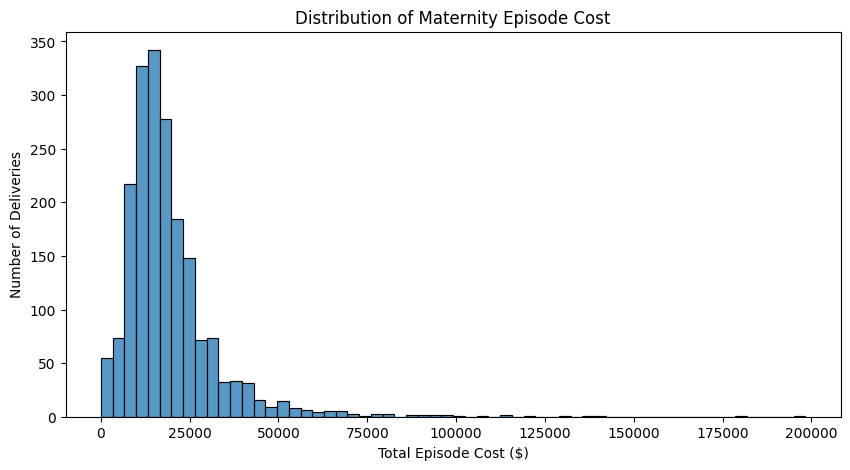

In [138]:
#Understand cost distribution

import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10,5))
sns.histplot(episodes['total_medical_cost'], bins=60)
plt.title("Distribution of Maternity Episode Cost")
plt.xlabel("Total Episode Cost ($)")
plt.ylabel("Number of Deliveries")
plt.show()


In [139]:
# STEP 3.4 Outlier detection (top 10% cost)

# High cost threshold (90th percentile)
p90 = episodes['total_medical_cost'].quantile(0.90)

high_cost = episodes[episodes['total_medical_cost'] >= p90]
low_cost = episodes[episodes['total_medical_cost'] < p90]

print("High cost episodes:", high_cost.shape)
print("Threshold ($):", round(p90,2))


High cost episodes: (197, 5)
Threshold ($): 32899.04


In [140]:
high_cost['total_medical_cost'].describe()


count       197.000000
mean      51962.011827
std       24878.052803
min       32899.040000
25%       37399.360000
50%       42544.580000
75%       55854.230000
max      198343.890000
Name: total_medical_cost, dtype: float64

## 4. Delivery Type Analysis (C-Section vs Vaginal)
Compare cost differences between C-section and vaginal deliveries.  
Evaluate whether surgical deliveries are major cost drivers.

In [141]:
#STEP 4.1 C-section vs vaginal delivery cost
episodes['drg'].value_counts()


drg
807    978
788    312
806    199
787    188
805     80
786     67
785     64
768     64
784     21
798      7
783      7
797      5
796      1
Name: count, dtype: int64

In [142]:
#4.2 Delivery classification using cost logic

vaginal_drg = ['768','807','798','806','785','788']
csection_drg = ['783','784','786','787','796','797','805']

episodes['delivery_type'] = 'Other'
episodes.loc[episodes['drg'].astype(str).isin(vaginal_drg), 'delivery_type'] = 'Vaginal'
episodes.loc[episodes['drg'].astype(str).isin(csection_drg), 'delivery_type'] = 'C-section'

episodes['delivery_type'].value_counts()


delivery_type
Vaginal      1624
C-section     369
Name: count, dtype: int64

In [143]:
episodes.groupby('drg')['total_medical_cost'].mean().sort_values().round(0)


drg
807    15264.0
798    16322.0
806    19337.0
768    21027.0
785    21239.0
788    21435.0
805    23112.0
787    27148.0
784    30257.0
797    33380.0
783    34652.0
786    37289.0
796    51175.0
Name: total_medical_cost, dtype: float64

In [144]:
#4.3 cost comparision between 2 groups 

episodes.groupby('delivery_type')['total_medical_cost'].agg([
    'count',
    'mean',
    'median',
    'min',
    'max'
]).round(2)


,count,mean,median,min,max
delivery_type,,,,,
C-section,361,28614.79,24110.46,0.0,198343.89
Vaginal,1600,17409.46,14860.36,0.0,137340.49


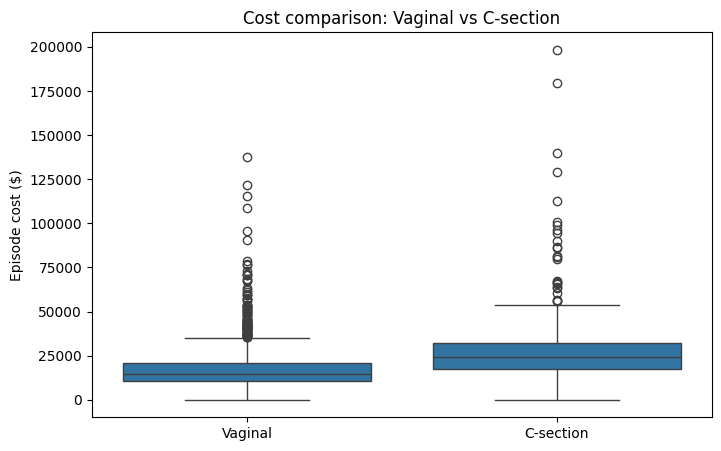

In [145]:
#4.4 Visual

import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8,5))
sns.boxplot(data=episodes, x='delivery_type', y='total_medical_cost')
plt.title("Cost comparison: Vaginal vs C-section")
plt.ylabel("Episode cost ($)")
plt.xlabel("")
plt.show()


In [146]:
episodes['high_cost_flag'] = (episodes['total_medical_cost'] >= p90).astype(int)

episodes.groupby('high_cost_flag')['total_medical_cost'].agg([
    'count','mean','median'
]).round(2)


,count,mean,median
high_cost_flag,,,
0,1764,15843.85,15044.60
1,197,51962.01,42544.58


**Insight:** Majority of deliveries are vaginal; however, C-sections represent a significant minority with higher associated costs.


## 5. High-Cost Episode Identification
Define high-cost pregnancies using 90th percentile threshold.  
Segment population into normal vs high-cost episodes.


In [147]:
# STEP 5.1 Compare high-cost vs normal deliveries

episodes['high_cost_flag'] = (episodes['total_medical_cost'] >= p90).astype(int)

episodes.groupby('high_cost_flag')['total_medical_cost'].agg([
    'count','mean','median'
]).round(2)


,count,mean,median
high_cost_flag,,,
0,1764,15843.85,15044.60
1,197,51962.01,42544.58


In [148]:
#5.2 Are C-sections driving high-cost episodes?
pd.crosstab(episodes['delivery_type'], episodes['high_cost_flag'], margins=True)


high_cost_flag,0,1,All
delivery_type,,,
C-section,283,86,369
Vaginal,1513,111,1624
All,1796,197,1993


In [149]:
pd.crosstab(
    episodes['delivery_type'],
    episodes['high_cost_flag'],
    normalize='index'
).round(3)


high_cost_flag,0,1
delivery_type,,
C-section,0.767,0.233
Vaginal,0.932,0.068


**Insight:** Majority of deliveries are vaginal; however, C-sections represent a significant minority with higher associated costs.


In [150]:
#5.3 Compare cost components

episodes.groupby(['delivery_type','high_cost_flag'])['total_medical_cost'].agg([
    'count','mean','median'
]).round(0)


count     mean   median
delivery_type high_cost_flag                         
C-section     0                 275  20353.0  20808.0
              1                  86  55032.0  41540.0
Vaginal       0                1489  15011.0  14298.0
              1                 111  49583.0  42848.0

**Insight:** C-section deliveries are substantially more expensive than vaginal deliveries, indicating surgical delivery as a major cost driver.


## 6. Utilization Drivers of Cost
Analyze inpatient length of stay and service utilization.  
Evaluate relationship between utilization intensity and total cost.


In [151]:
#6.1 Length of stay = biggest cost driver

episodes['los'] = (episodes['delivery_disch'] - episodes['delivery_admit']).dt.days

episodes.groupby('high_cost_flag')['los'].agg(['count','mean','median','max'])

#Initial LOS results suggested extremely long stays (up to 600 days), indicating presence of readmissions or data anomalies. LOS was cleaned to reflect realistic maternity hospitalization windows.

,count,mean,median,max
high_cost_flag,,,,
0,1764,13.232426,2.0,614.0
1,197,60.868020,3.0,597.0


In [152]:
episodes['los_clean'] = episodes['los']

#6.2 remove outlier LOS > 30 days (not maternity stay)
episodes.loc[episodes['los_clean'] > 30, 'los_clean'] = None

episodes.groupby('high_cost_flag')['los_clean'].agg(['count','mean','median','max'])


,count,mean,median,max
high_cost_flag,,,,
0,1727,2.412855,2.0,26.0
1,170,4.211765,3.0,28.0


In [153]:
#6.3 What specifically causes high cost?
# cost by delivery type
episodes.groupby('delivery_type')['total_medical_cost'].agg(['count','mean','median'])


,count,mean,median
delivery_type,,,
C-section,361,28614.785125,24110.460
Vaginal,1600,17409.460031,14860.365


In [154]:
#6.4 LOS by delivery type
episodes.groupby('delivery_type')['los_clean'].agg(['mean','median'])


,mean,median
delivery_type,,
C-section,3.502874,3.0
Vaginal,2.365397,2.0


In [155]:
#6.5 percent high cost within each delivery type
pd.crosstab(episodes['delivery_type'], 
            episodes['high_cost_flag'], 
            normalize='index')


high_cost_flag,0,1
delivery_type,,
C-section,0.766938,0.233062
Vaginal,0.931650,0.068350


In [156]:
#6.6 What actually causes high cost inside C-sections?

# LOS difference inside C-section only
episodes[episodes['delivery_type']=="C-section"].groupby('high_cost_flag')['los_clean'].agg(['count','mean','median','max'])


,count,mean,median,max
high_cost_flag,,,,
0,270,3.100000,3.0,19.0
1,78,4.897436,3.0,28.0


**Insight:** High-cost pregnancies show longer inpatient stays and higher utilization, suggesting complications and intensive care needs.


## 7. Gestational Diabetes Risk Analysis
Identify pregnancies with gestational diabetes using diagnosis codes.  
Compare cost and utilization vs non-diabetic pregnancies.


In [157]:
episodes.shape


(1993, 9)

In [158]:
# ==============================
# 7.1 IDENTIFY GESTATIONAL DIABETES
# ==============================

diag_cols = [c for c in med.columns if 'icddiag' in c]

def has_diabetes(row):
    for val in row:
        if pd.notna(val):
            code = str(val)
            if code.startswith('O24'):
                return 1
    return 0

med['diabetes_flag'] = med[diag_cols].apply(has_diabetes, axis=1)

print("Diabetes claims found:", med['diabetes_flag'].sum())


Diabetes claims found: 8587


In [159]:
# =========================================
# 7.2 Collapse diabetes to pregnancy episode level
# =========================================

diabetes_episode = (
    med.groupby('memberid')['diabetes_flag']
       .max()
       .reset_index()
       .rename(columns={'diabetes_flag': 'diabetes_episode_flag'})
)

# merge into episodes table
episodes = episodes.merge(diabetes_episode, on='memberid', how='left')

# fill missing
episodes['diabetes_episode_flag'] = episodes['diabetes_episode_flag'].fillna(0).astype(int)

# incidence count
episodes['diabetes_episode_flag'].value_counts()


diabetes_episode_flag
0    1736
1     257
Name: count, dtype: int64

In [160]:
# =========================================
# 7.3 COST COMPARISON: diabetes vs normal
# =========================================

episodes.groupby('diabetes_episode_flag')['total_medical_cost'].agg(['count','mean','median'])


,count,mean,median
diabetes_episode_flag,,,
0,1709,18852.114599,15642.44
1,252,23677.815992,19896.33


In [161]:
#7.4 C-section : Diabetes vs normal 

pd.crosstab(episodes['diabetes_episode_flag'], episodes['delivery_type'], normalize='index')


delivery_type,C-section,Vaginal
diabetes_episode_flag,,
0,0.172811,0.827189
1,0.268482,0.731518


In [162]:
#7.5 LOS

episodes.groupby('diabetes_episode_flag')['los_clean'].agg(['count','mean','median','max'])


,count,mean,median,max
diabetes_episode_flag,,,,
0,1655,2.549849,2.0,28.0
1,242,2.739669,2.0,11.0


In [163]:
#7.6 High-cost risk
pd.crosstab(
    episodes['diabetes_episode_flag'],
    episodes['high_cost_flag'],
    normalize='index'
)


high_cost_flag,0,1
diabetes_episode_flag,,
0,0.910714,0.089286
1,0.836576,0.163424


**Insight:** Pregnancies with gestational diabetes demonstrate higher average costs and increased likelihood of complications.


## 8. Predictive Modeling: High-Cost Risk
Build logistic regression model to predict high-cost pregnancies.  
Key predictors evaluated:
- C-section delivery
- Gestational diabetes
- Length of stay


In [164]:
#8.1 Prediction analysis : Which pregnancies becomes expensive/ high-cost? 

#############################################
# BUILD PREDICTION DATASET
#############################################

model_df = episodes.copy()

# convert categorical
model_df['csection_flag'] = (model_df['delivery_type'] == 'C-section').astype(int)

# keep only usable columns
model_df = model_df[[
    'high_cost_flag',
    'diabetes_episode_flag',
    'csection_flag',
    'los_clean',
    'total_medical_cost'
]]

model_df = model_df.dropna()

model_df.head()


,high_cost_flag,diabetes_episode_flag,csection_flag,los_clean,total_medical_cost
0,0,0,0,2.0,8021.34
1,0,0,0,2.0,13332.89
2,0,0,1,3.0,20397.16
3,0,1,1,2.0,24838.50
4,0,0,0,2.0,25807.81


In [165]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

X = model_df[['diabetes_episode_flag','csection_flag','los_clean']]
y = model_df['high_cost_flag']

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.3,random_state=42)

model = LogisticRegression()
model.fit(X_train,y_train)

print("Model trained")

Model trained


In [166]:
import pandas as pd

coeff = pd.DataFrame({
    "Feature": X.columns,
    "Impact_on_high_cost": model.coef_[0]
}).sort_values(by="Impact_on_high_cost", ascending=False)

coeff


,Feature,Impact_on_high_cost
1,csection_flag,1.263830
0,diabetes_episode_flag,0.413585
2,los_clean,0.295950


**Insight:** C-section delivery, gestational diabetes, and length of stay are the strongest predictors of high-cost maternity episodes.


## 9. Risk Stratification

We segmented pregnancies into Low, Medium, and High-risk groups based on predicted probability of becoming high-cost.
High-risk pregnancies show significantly higher average episode costs compared to low-risk pregnancies.


In [167]:
#9.1 create risk score in model_df first
model_df['risk_score'] = model.predict_proba(
    model_df[['diabetes_episode_flag','csection_flag','los_clean']]
)[:,1]

model_df[['risk_score']].describe()


,risk_score
count,1897.000000
mean,0.096308
std,0.105804
min,0.028085
25%,0.049636
50%,0.055488
75%,0.086256
max,0.997543


In [168]:
#9.2 create risk tiers 

model_df['risk_group'] = pd.qcut(
    model_df['risk_score'],
    q=3,
    labels=['Low','Medium','High']
)

model_df['risk_group'].value_counts()


risk_group
Low       918
High      624
Medium    355
Name: count, dtype: int64

In [169]:
#9.3 compare cost by risk tiers 

model_df.groupby('risk_group')['total_medical_cost'].agg(['count','mean','median','max']).round(0)


,count,mean,median,max
risk_group,,,,
Low,918,14772.0,13357.0,78842.0
Medium,355,18416.0,15938.0,108649.0
High,624,25261.0,21471.0,198344.0


**Insight:** Predicted high-risk pregnancies show significantly higher average costs, validating the effectiveness of the risk stratification model.


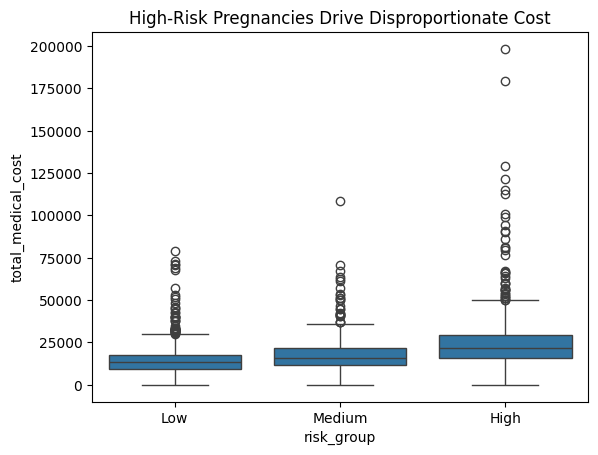

In [170]:
sns.boxplot(data=model_df, x='risk_group', y='total_medical_cost')
plt.title("High-Risk Pregnancies Drive Disproportionate Cost")
plt.show()


## 10. Financial Impact & Cost Reduction Opportunity
Estimate potential savings if high-risk pregnancies are proactively managed.  
Model assumes 15% cost reduction via care management interventions.


In [171]:
#10.1 savings analysis 

high_risk = model_df[model_df['risk_group']=="High"]

total_high_cost = high_risk['total_medical_cost'].sum()

potential_savings = total_high_cost * 0.15

total_high_cost, potential_savings


(np.float64(15762976.780000001), np.float64(2364446.517))

**Insight:** Proactive management of high-risk pregnancies could generate substantial cost savings while improving maternal outcomes.


## 11. Strategic Insights for Payers

Key Findings:
- High-risk pregnancies cost significantly more than low-risk
- C-sections and diabetes are primary cost drivers
- Early risk identification enables targeted intervention

Business Implication:
Predictive maternity risk programs can reduce avoidable spend and improve maternal outcomes.


In [172]:
#11.1 Intervention logic - Strategy

# ==========================================
# INTERVENTION TARGETING STRATEGY
# ==========================================

high_risk_cases = model_df[model_df['risk_group']=="High"]

print("High-risk pregnancies:", len(high_risk_cases))
print("Avg cost:", round(high_risk_cases['total_medical_cost'].mean(),0))
print("Total cost:", round(high_risk_cases['total_medical_cost'].sum(),0))


High-risk pregnancies: 624
Avg cost: 25261.0
Total cost: 15762977.0


## Strategic Recommendations for Payers
- Implement early risk stratification using claims data
- Prioritize care management for high-risk pregnancies
- Reduce avoidable C-section rates where clinically appropriate
- Proactively manage gestational diabetes cases
- Use predictive modeling to guide maternity care programs


Strategic intervention plan for payer

Target group: High-risk pregnancies identified via predictive model

1. Diabetes management program

- early screening
- glucose monitoring
- maternal care coordination
- Goal: reduce complications + NICU use

2. C-section reduction initiative

- flag avoidable C-sections
- second-opinion program
- provider incentives
- Goal: shift to vaginal when safe

3. Length-of-stay optimization

- discharge planning
- home nurse follow-up
- remote monitoring
- Goal: reduce inpatient days

4. Expected financial impact

High-risk pregnancy cost pool: $15.7M
Potential reduction: 15–25%
Potential savings: $2–4M annually

## Conclusion
This project demonstrates how raw claims data can be transformed into actionable payer strategy using episode analytics and predictive modeling.
